In [223]:
import numpy as np
import pylab
from matplotlib.pyplot import figure

import pylab
import matplotlib
from matplotlib.pyplot import figure
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.opflow import X, Z, Y, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.circuit.library import TwoLocal, QAOAAnsatz

from qiskit.algorithms.optimizers import ADAM, CG, COBYLA, L_BFGS_B, GradientDescent, NELDER_MEAD, \
                                            NFT, POWELL, SLSQP, SPSA, TNC


#Imports Functions for Building Hamiltonains
%run Utils.ipynb
np.set_printoptions(formatter={'float': '{:0.3f}'.format})

# Parameters

In [224]:
#use even number of qubits for Schwinger
N = 4 #qubits
g = 1 #coupling
m = 1 #bare mass
a = 1 #lattice spacing
theta = np.pi #topological term

# Coefficient Matrix

In [225]:
mixer_coupling = CouplingMatrix(N)    
target_coupling = CouplingMatrix(N)

H_E_coeff = (g**2)*a / 2
H_M_coeff = m / 2
H_I_coeff = 1 / (4 * a)

#Constant
I_coeff = (1/4.0) * (N * (theta/np.pi)**2 + np.ceil(N/2.0) * (1-2*(theta/np.pi)) + ((N*(N-1))/2)) * H_E_coeff
print(f"I:\n{I_coeff}")

#H_E
for i in range(N):
    for j in range(0, i):
        target_coupling[i + 2*N, j + 2*N] += (N-i) / 2.0 * H_E_coeff


for i in range(N):
    target_coupling[i + 2*N,i + 2*N] += (1/2.0) * ((theta/np.pi) * (N-i+1) - np.ceil((N-i+1)/2)) * H_E_coeff
    
#H_M
for i in range(N):
    target_coupling[i + 2*N,i + 2*N] += ((-1) ** (i+1)) * H_M_coeff

#H_I
for i in range(N-1):
    mixer_coupling[i,i + 1] += H_I_coeff
    mixer_coupling[i + N,i + 1 + N] += H_I_coeff

print(f"\nX:\n{mixer_coupling.X}")
print(f"\nY:\n{mixer_coupling.Y}")
print(f"\nZ:\n{target_coupling.Z}")

I:
1.0

X:
[[0.000 0.250 0.000 0.000]
 [0.250 0.000 0.250 0.000]
 [0.000 0.250 0.000 0.250]
 [0.000 0.000 0.250 0.000]]

Y:
[[0.000 0.250 0.000 0.000]
 [0.250 0.000 0.250 0.000]
 [0.000 0.250 0.000 0.250]
 [0.000 0.000 0.250 0.000]]

Z:
[[0.000 0.750 0.500 0.250]
 [0.750 1.000 0.500 0.250]
 [0.500 0.500 -0.250 0.250]
 [0.250 0.250 0.250 0.750]]


# Build Hamiltonian
Converts the matrix representation into a PauliSumOp Hamiltonian in order to be run on VQE

In [226]:
mixer_hamiltonian = mixer_coupling.getHamiltonian()
target_hamiltonian = target_coupling.getHamiltonian()

complete_hamiltonian = mixer_hamiltonian + target_hamiltonian

print(target_hamiltonian)
print(mixer_hamiltonian)

0.75 * ZZII
+ 1.0 * IZII
+ 0.5 * ZIZI
+ 0.5 * IZZI
- 0.25 * IIZI
+ 0.25 * ZIIZ
+ 0.25 * IZIZ
+ 0.25 * IIZZ
+ 0.75 * IIIZ
0.25 * XXII
+ 0.25 * IXXI
+ 0.25 * IIXX
+ 0.25 * YYII
+ 0.25 * IYYI
+ 0.25 * IIYY


# Ansatz

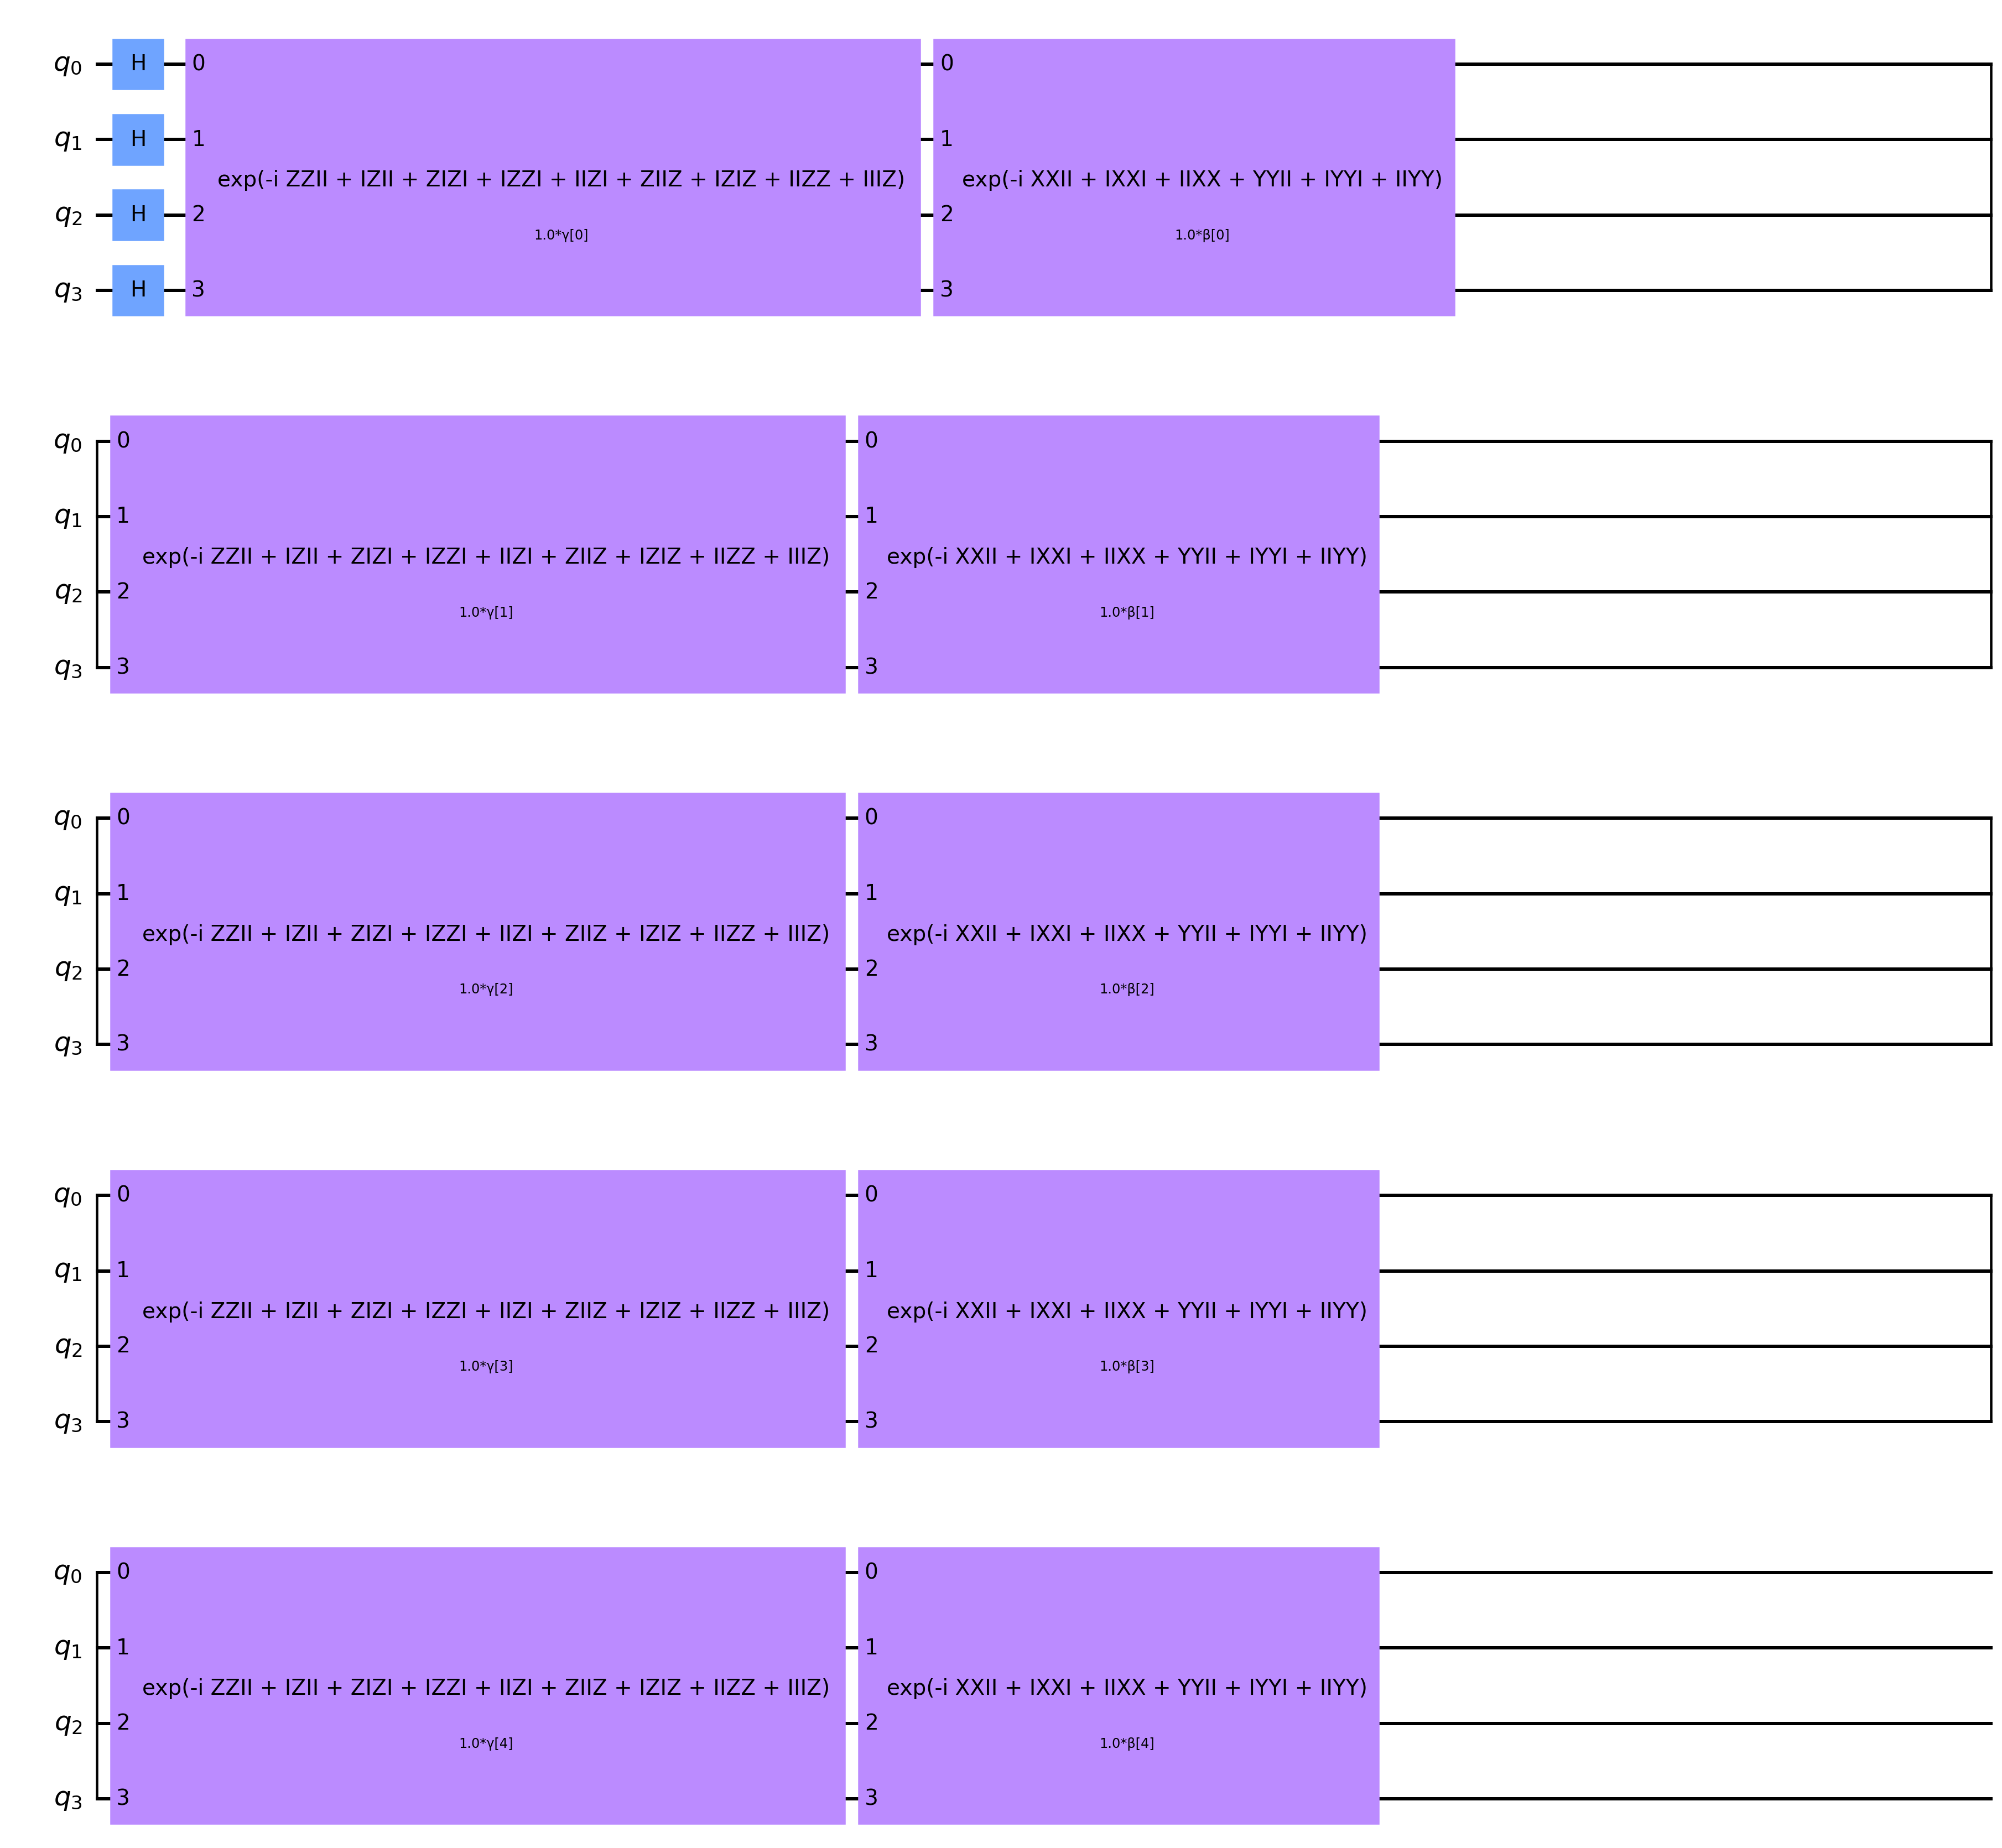

In [232]:
ansatz = QAOAAnsatz(cost_operator= target_hamiltonian, 
                    reps=5, 
                    initial_state=None, 
                    mixer_operator= mixer_hamiltonian, 
                    name='QAOA')

%matplotlib inline
ansatz.decompose().draw(output = "mpl", scale = 3)

# Optimizers

In [233]:
max_iters = 10000

optimizers = [COBYLA,L_BFGS_B]

#post-processing
optimizers = setOptimizers(optimizers)

ADAM            OFF
CG              OFF
COBYLA          ON
L_BFGS_B        ON
GradientDescent OFF
NELDER_MEAD     OFF
NFT             OFF
POWELL          OFF
SLSQP           OFF
SPSA            OFF
TNC             OFF


# Run VQE

In [234]:
#options
verbose = False
vqe_iterations = 1

#implementation
converge_cnts = np.zeros([len(optimizers)], dtype=object)
converge_params = np.zeros([len(optimizers)], dtype=object)
converge_vals = np.zeros([len(optimizers)], dtype=object)

for j in range(vqe_iterations):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        counts = []
        params = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            params.append(parameters)
            values.append(mean)

        vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
                  quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=complete_hamiltonian)
        if verbose:
            print(f"\n{result}")
        converge_cnts[i] = np.asarray(counts)
        converge_params[i] = np.asarray(params)
        converge_vals[i] = np.asarray(values)
    print(f'\rOptimization {j+1} complete      ');

Optimization 1 complete      


# Results Graph

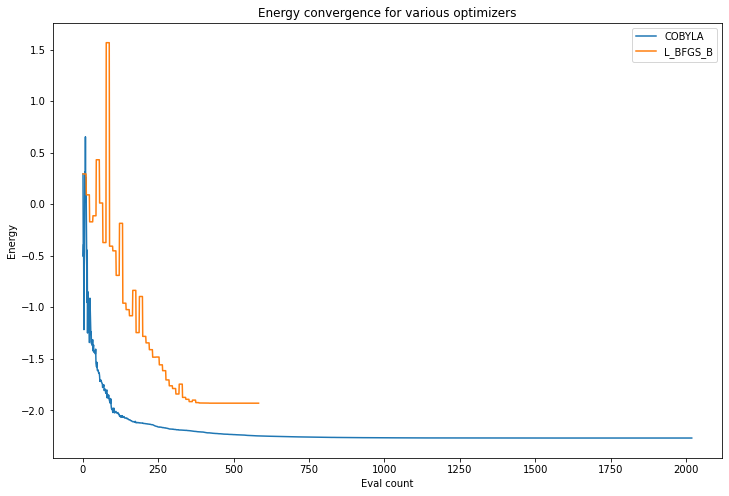

In [235]:
figure(dpi=120)
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');


# Results Statistics

The error is calculated by the following equation
$$\text{Error} = {\frac{\lvert E_{VQE} - E_{min} \rvert}{\lvert E_{max} - E_{min} \rvert}}$$

In [236]:
npme = NumPyMinimumEigensolver()
max_result = npme.compute_minimum_eigenvalue(operator= -1 * (complete_hamiltonian))
min_result = npme.compute_minimum_eigenvalue(operator= complete_hamiltonian)

max_energy = max_result.eigenvalue.real * -1
min_energy = min_result.eigenvalue.real
energy_range = abs(max_energy - min_energy)

print(f'Maximum Energy: {max_energy:.5f}')
print(f'Minimum Energy: {min_energy:.5f}')
print(f'Energy Range: {energy_range:.5f}')

for i, optimizer in enumerate(optimizers):
    error = abs(converge_vals[i][-1] - min_energy)/energy_range * 100
    #print the parameters
    print(f"\n{type(optimizer).__name__}")
    print(f"Params: {converge_params[i][-1]}")
    print(f"Energy: {converge_vals[i][-1]}")
    print(f"Error: {error:.5f}%")

Maximum Energy: 4.00000
Minimum Energy: -3.30446
Energy Range: 7.30446

COBYLA
Params: [5.580 5.315 5.613 5.621 1.227 1.851 -5.313 0.600 -0.783 -3.499]
Energy: -2.2699712733001216
Error: 14.16240%

L_BFGS_B
Params: [5.516 3.849 2.068 6.283 1.520 0.836 -5.815 0.301 -1.841 -3.675]
Energy: -1.9317293299317313
Error: 18.79302%


In [164]:
g_range = [np.infty, -np.infty , 0]
b_range = [np.infty, -np.infty , 0]
for i, optimizer in enumerate(optimizers):
    g, b = converge_params[i][:, 0], converge_params[i][:, 1]
    g_range[0] = min(g_range[0], np.floor(min(g)))
    g_range[1] = max(g_range[1], np.ceil(max(g)))
    
    b_range[0] = min(b_range[0], np.floor(min(b)))
    b_range[1] = max(b_range[1], np.ceil(max(b)))

g_range[2] = g_range[1] - g_range[0]
b_range[2] = b_range[1] - b_range[0]

g_range, b_range = list(map(int, g_range)), list(map(int, b_range))

print("Calculated Range")
print(f"Gamma: {g_range[0]} - {g_range[1]} : {g_range[0]}")
print(f"Beta:  {b_range[0]} - {b_range[1]} : {b_range[2]}")

Calculated Range
Gamma: 2 - 6 : 2
Beta:  4 - 10 : 6


# Energy Landscape

In [ ]:
def calcEnergy(x, y):
    return vqe.get_energy_evaluation(complete_hamiltonian)([x,y])

def renderLandscape(g_range, b_range, quality = 1):
    print(quality)
    gamma_range = (g_range[1] - g_range[0]) * quality
    beta_range = (b_range[1] - b_range[0]) * quality

    gamma = np.linspace(g_range[0], g_range[1], gamma_range)
    beta = np.linspace(b_range[0], b_range[1], beta_range)

    gamma, beta = np.meshgrid(gamma, beta)

    energy = np.zeros([beta_range, gamma_range ], dtype=float)

    ttl = beta_range * gamma_range

    print("Rendering...")
    for i in range(beta_range):
        for j in range(gamma_range):
            energy[i,j] = calcEnergy(gamma[i,j], beta[i,j])
            print(f'{((i * gamma_range) + j + 1) / ttl * 100 :3.2f}%', end='\r', flush = True)
    print("\nDone!")   
    
    return gamma, beta, energy

gamma, beta, energy = renderLandscape([0,10], [0,10], 5)

5
Rendering...


<IPython.core.display.Javascript object>


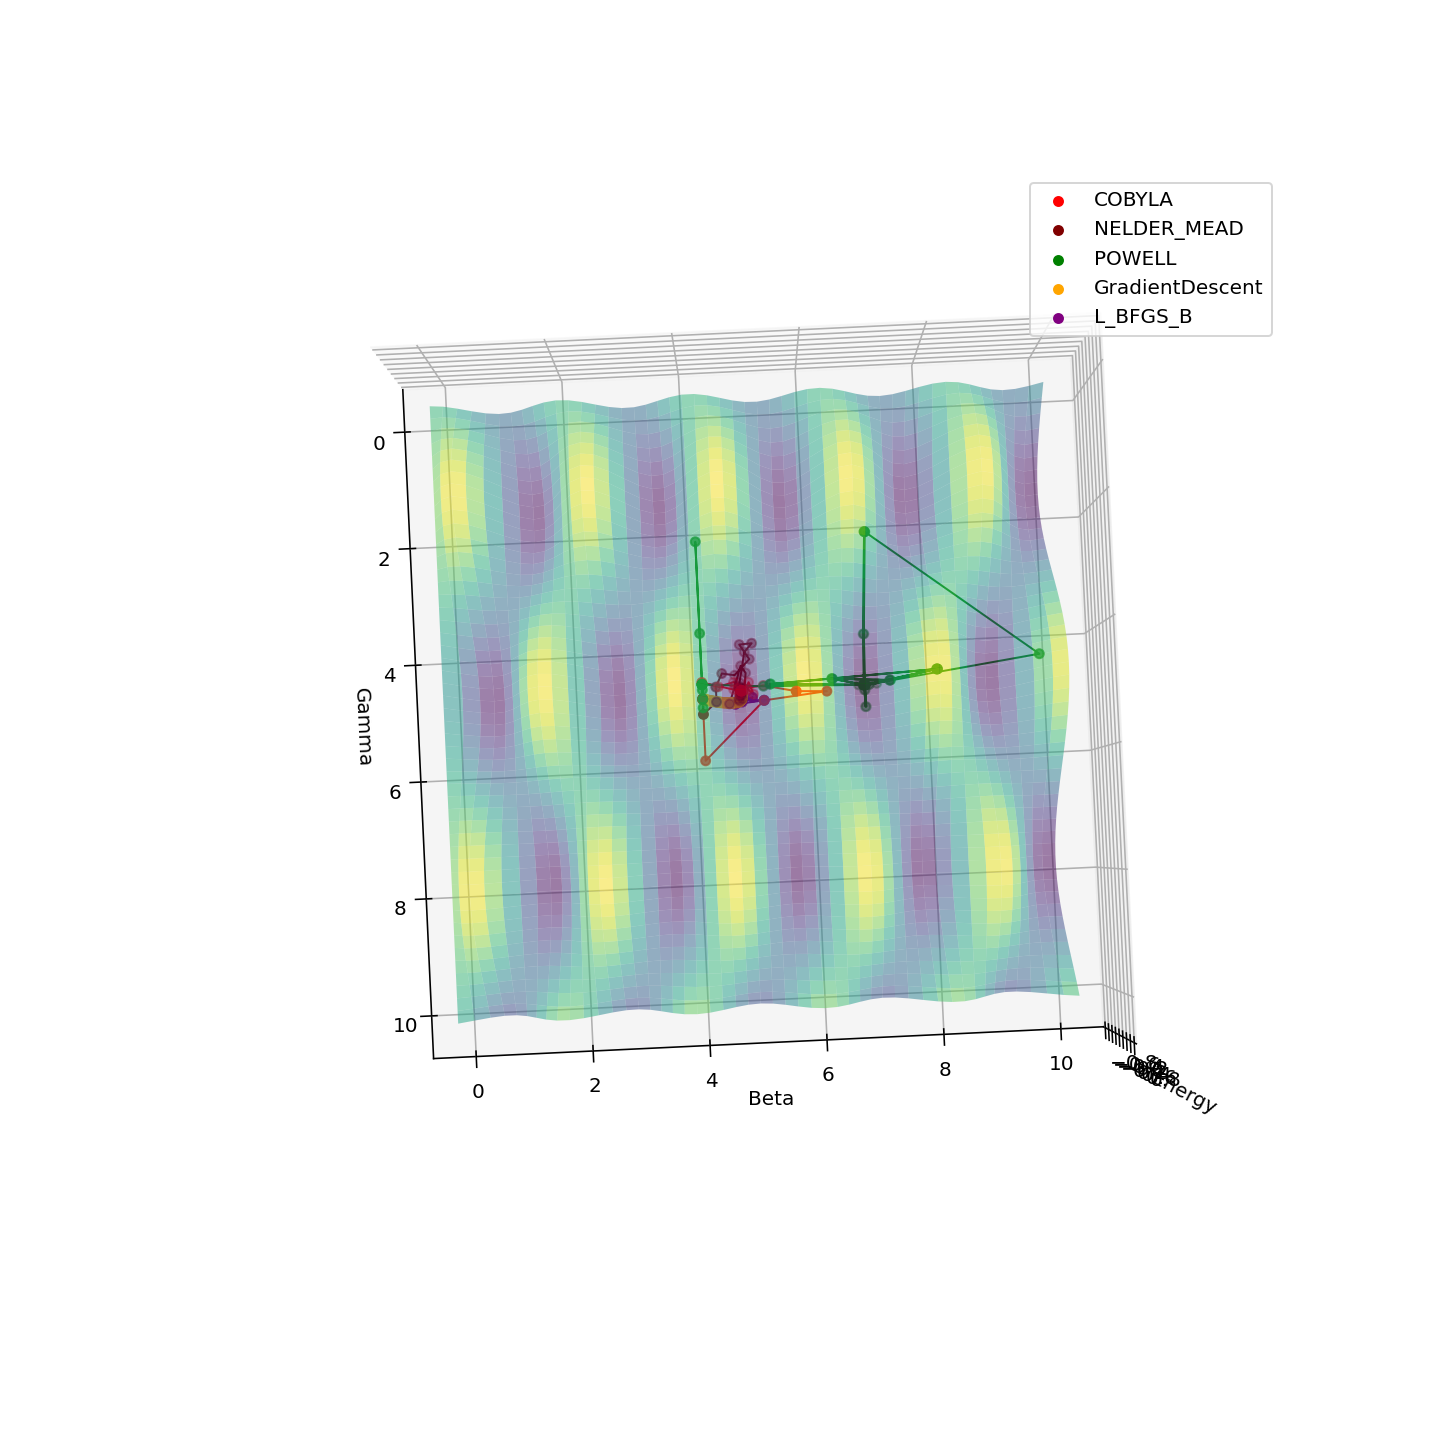

In [182]:
%matplotlib notebook
colors = ['red', 'maroon', 'green', 'orange', 'purple', 'cyan', 'pink', 'magenta', 'olive']


matplotlib.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure(1)
ax = plt.axes(projection='3d')

sub_min = 0
sub_max = 50

ax.plot_surface(gamma, beta, energy, cmap='viridis',edgecolor='none', alpha = 0.5)

for i, optimizer in enumerate(optimizers):
    ax.scatter(converge_params[i][:, 0], converge_params[i][:, 1], converge_vals[i], color = colors[i], linewidth=1, label=type(optimizer).__name__)
    ax.plot3D(converge_params[i][:, 0], converge_params[i][:, 1], converge_vals[i], color = colors[i], linewidth=1)

ax.set_xlabel('Gamma')
ax.set_ylabel('Beta')
ax.set_zlabel('Energy');

pylab.legend(loc='upper right');
